In [91]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
import datetime
import itertools
# from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.patheffects as pe
%matplotlib notebook

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline
%config IPCompleter.greedy=True

import scipy
from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
# from sklearn.externals 
import joblib
from matplotlib import cm

import matplotlib as mpl
mpl.rcParams["mathtext.default"] = 'regular'

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
def Performance(ax,title,target,verbose,lim=None):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
            yerr=target.level_best['SE'].values*target.Rule,color='grey',
            alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.Rule,
           color='red',alpha = 1,label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule])
    plt.sca(ax)
    plt.grid()
    if lim is not None:
        ax.set_xlim(lim)
        yaxy.set_xlim(lim)
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        print(i,mod)
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    if verbose>1:
        print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
    else:
#         alpha = .025
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',alpha = 1,label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',alpha = 1,label='Parsimony')
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
    ax.grid()
    print(Data)

def Mapper(AllData,target,name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    print(target.params['target'],target.params['Inputs'],
                       target.params['Spath'])
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                       ScalePath=target.params['Spath'],Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                   ScalePath=target.params['Spath'],Project=True,fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[name] = target.Data_Map[target.target].values
#     print(AllData[name])
    AllData[name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[name+'_CI'] = target.Data_Map['CI'].values
    AllData[name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

def PooledVar_interval(Data,Vars,mean,n): 
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)**2+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)**2).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux**2
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
    return(SigmaX)

class ResultMap:
    def __init__(self,Path,target,Test='N/A',Rule=1,alpha = .025,DataName ='AllData.csv', AltPath=None,Site='FishIsland',FPVars=None):
        self.FPVars = FPVars
        self.target = target        
        self.params = Dense.Params(Path,'Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,DataName,FPVars = FPVars)
        if AltPath is None:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += target+'/'
        else:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+AltPath+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += AltPath+'/'           
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Nodes'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        self.Best = self.Records.loc[self.Records.index==Rule]
        self.Model_Selection = self.Best['Model'].values[0]
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
        self.params['Spath']=(self.params['Dpath']+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
        display(prog1)
        self.Weights=[]
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.Best['K'].values[0]))):
                prog1.value+=1
                Y = results[0]
                self.Weights.append(results[1])
#                 print(Y)
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
        YTru = self.RST.y+0.0
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        
        for k in range(0,1):
            results=Dense.Load_Model(k,X=X,params=self.params)
            YVar = results[0]
            YVar = YStandard.inverse_transform(YVar)                    
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        self.Y_fill = Y_fill
        self.Y_fill_bar = Y_fill_bar
        
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def RecRead(Path):
    AllRes={}
    for f in ['fco2','fch4']:#,'ER']:
        try:
            AllRes[f]={}
            AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
            AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
            AllRes[f]['Derivatives']={}
            AllRes[f]['SSQ'] ={}
            AllRes[f]['X'] = {}
            AllRes[f]['Yhat'] = {}
            AllRes[f]['Ytrue'] = {}
            AllRes[f]['Outputs'] = {}
        except:
            pass
    return(AllRes)

def DerivKeys(Resluts,col): 
    i =0
    Keys = {}
    for f,r in zip(Results.Factors.values,Results[col].values):
        if r > 0:
            Keys[f]=i
            i += 1
    return(Keys)

NameDict = {}
for k,n in zip(Variables,Aliases):
    NameDict[k]=n
    
    

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Path = 'C:\\Users\\wesle\\NetworkAnalysis\\'

Site = 'FishIsland/'
Path = Path+Site
AllRes = RecRead(Path = Path) 

In [92]:

Variables=['fch4','fco2','Air Temp','Rainfall','Wind Speed','Wind direction',
        'Net SW Radiation','Net LW Radiation ','Net Radiation',
       'DOY','Daytime','DSSM','NDVI','Angle',
       'tsoil_0','tsoil_10','soilw_0','soilw_10',
       'Deep','Shallow','VPD_est']

Aliases=['fch4','fco2','Air Temp','Rainfall','Wind Speed','Wind direction',
        'Net SW Radiation','Net LW Radiation ','Net Radiation',
       'DOY','Daytime','DSSM','NDVI','Angle',
       'tsoil_0','tsoil_10','soilw_0','soilw_10',
       'T$_{soil 15 cm}$','T$_{soil 5 cm}$','VPD*']

In [93]:
for i,F in enumerate(['fco2','fch4']):
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
#     print(Records['Remove'])
    MBE = []
    MBEs = []
    RMSE = []
    RMSEs = []
    r2 = []
    SDev = []

    for I in Records.index:
        
        y = np.load(Path+F+'_Yhat_'+I+'.npy')#.mean(axis=0)
        x = np.load(Path+F+'_Ytrue_'+I+'.npy')#.mean(axis=0)
        K = y.shape[0]
        df = pd.DataFrame(data={'target':y.flatten(),'y':x.flatten()}).dropna()

        mbe = (np.nansum((x-y),axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))
        MBEs.append(mbe.std())

        rmse = (np.nansum((x-y)**2,axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))**.5
        RMSEs.append(rmse.std())

        MBE.append((df['y']-df['target']).sum()/df['y'].count())
        SDev.append(np.abs(df['y']-df['target']).sum()/df['y'].count()*2**.5)
        RMSE.append(metrics.mean_squared_error(df['y'],df['target'])**.5)
        r2.append(metrics.r2_score(df['y'],df['target']))

    RMSEs=np.array(RMSEs)
    MBEs=np.array(MBEs)

    df = pd.DataFrame(index = Records.index,data = {'RMSE':RMSE,'SE':RMSEs/(K**.5),'MBE':MBE,'MBESE':MBEs/(K**.5),'R2':r2})
    df['Diff']=df['RMSE'].diff()
    Xlbls = []
    for v in Records.Remove:
        try:
            Xlbls.append(NameDict[v])
        except:
            Xlbls.append('N/A')
            pass
    df = df.iloc[::-1]
    df['Factor']=Xlbls[::-1]
    
    Mn = (df.loc[df['RMSE']==df['RMSE'].min()])
    Mn = (df.loc[df['R2']==df['R2'].max()])
    df['PCT'] = Mn['RMSE'].values[0]/df['RMSE']
    
#     print(Mn[['Factor','R2','RMSE','Diff','MBE']].round(3))
    df['MX']=df['RMSE']+df['SE']
    df['RMSE_MX']=df['MX']-df['RMSE']
    print(df[['Factor','R2','RMSE','SE','MX','RMSE_MX']].round(3)[::-1])
    

     Factor     R2   RMSE     SE     MX  RMSE_MX
7_40    N/A  0.913  0.440  0.004  0.444    0.004
6_40    N/A  0.910  0.446  0.004  0.450    0.004
     Factor     R2   RMSE     SE     MX  RMSE_MX
7_24    N/A  0.589  7.949  0.073  8.022    0.073
6_24    N/A  0.585  7.990  0.067  8.058    0.067


                                                                        Model  \
7_24  Net SW Radiation+Net LW Radiation +Wind Speed+NDVI+Deep+Shallow+VPD_est   
6_24                    Net SW Radiation+Wind Speed+NDVI+Deep+Shallow+VPD_est   

      Size  Nodes        MSE      RMSE        SE        r2  Performance   K  \
7_24     7     24  60.205043  7.759191  1.155962  0.602677            0  30   
6_24     6     24  61.101260  7.816729  1.087259  0.596762            0  30   

         Thresh  Remove  
7_24  61.361005     NaN  
6_24  62.188519     NaN  
                                                      Model  Size  Nodes  \
6_24  Net SW Radiation+Wind Speed+NDVI+Deep+Shallow+VPD_est     6     24   

           MSE      RMSE        SE        r2  Performance   K     Thresh  \
6_24  61.10126  7.816729  1.087259  0.596762            0  30  62.188519   

      Remove  
6_24     NaN  
            Factors  RC_Sum: 6_24  Cumsum
0              NDVI         0.059   1.000
1        Wind Speed 

<IPython.core.display.Javascript object>


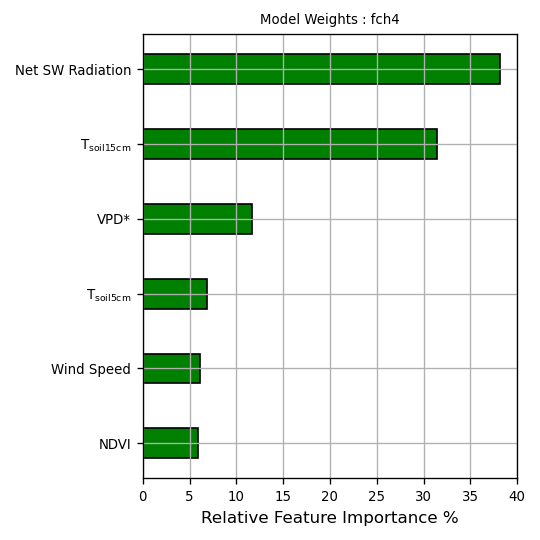

<IPython.core.display.Javascript object>


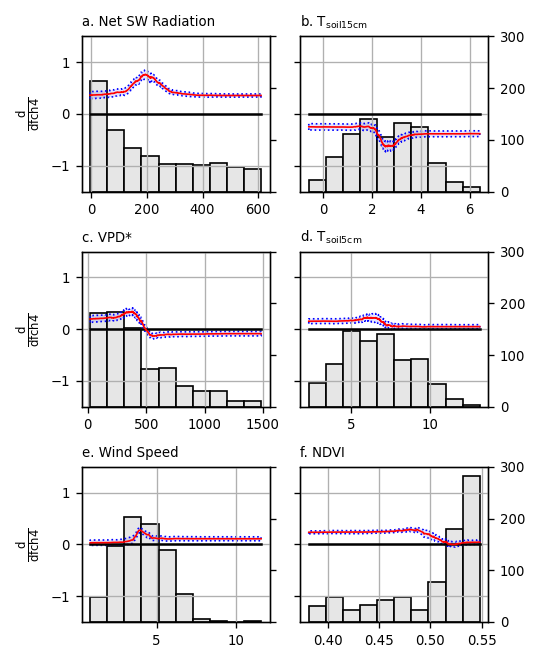

                                                                        Model  \
7_40  Net SW Radiation+Net LW Radiation +Wind Speed+NDVI+Deep+Shallow+VPD_est   
6_40             Net SW Radiation+Net LW Radiation +NDVI+Deep+Shallow+VPD_est   

      Size  Nodes       MSE      RMSE        SE        r2  Performance   K  \
7_40     7     40  0.175974  0.419493  0.003717  0.919570            0  30   
6_40     6     40  0.185103  0.430236  0.003658  0.915397            0  30   

        Thresh  Remove  
7_40  0.179691     NaN  
6_40  0.188760     NaN  
                                                             Model  Size  \
6_40  Net SW Radiation+Net LW Radiation +NDVI+Deep+Shallow+VPD_est     6   

      Nodes       MSE      RMSE        SE        r2  Performance   K   Thresh  \
6_40     40  0.185103  0.430236  0.003658  0.915397            0  30  0.18876   

      Remove  
6_40     NaN  
             Factors  RC_Sum: 6_40  Cumsum
0               Deep         0.011   1.000
1             

<IPython.core.display.Javascript object>


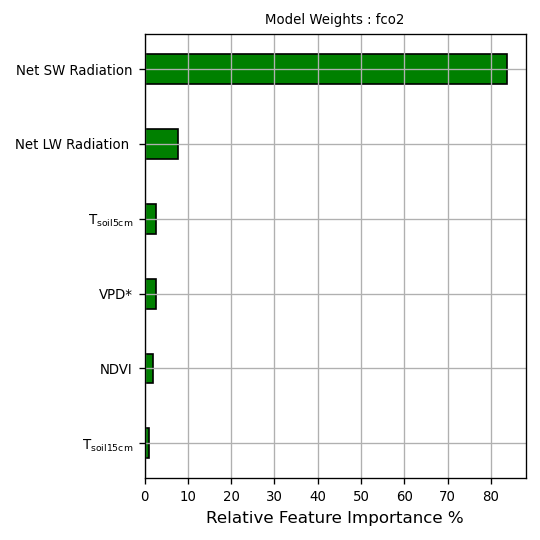

<IPython.core.display.Javascript object>


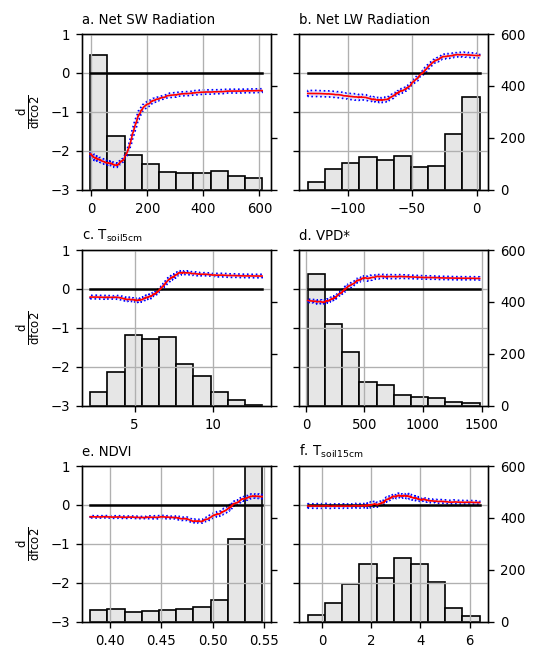

In [94]:
co2_Model_Index = '6_40'
ch4_Model_Index = '6_24'    
if Site == 'FishIsland_JustMet/':
    co2_Model_Index = '4_75'
    ch4_Model_Index = '4_43'

for i,F in enumerate(['fch4','fco2']):
    RSM = 0
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
    print(Records)
    
    Model_Index = co2_Model_Index
    if F == 'fch4':
        Model_Index = ch4_Model_Index
    elif F == 'ER':
        Model_Index = ER_Model_Index
    if Model_Index == None:
        Best = Records.loc[Records['Size']==Records['Size'].min()]
    else:
        Best = Records.loc[Records.index==Model_Index]    
    print(Best)
    Size = Best.Size.values[0]
    Nodes = Best.Nodes.values[0]
    # N = Records.Size.max()
    Records['RMSE']=Records['MSE']**.5
    Records['RSE']=Records['SE']**.5
    Best_U = 'RC_Sum: '+Best.index.values[0]
    
    Derivatives = np.load(Path+F+'_Derivatives_'+Best.index.values[0]+'.npy')
    Mean = Derivatives.mean(axis=0)
    Std = Derivatives.std(axis=0)
    X = np.load(Path+F+'_X_'+str(Size)+'.npy')

    Deriv_Labels= DerivKeys(Results,Best_U)
    SubSet = Results.loc[Results[Best_U]>0].sort_values(Best_U,ascending=True).reset_index()

    SubSet['Cumsum']=SubSet[Best_U].sort_values(ascending=False).cumsum().sort_values(ascending=False)
    print(SubSet[['Factors',Best_U,'Cumsum']].round(3))
    print(SubSet['Factors'].values)
    
    fig,ax=plt.subplots(figsize=(4.5,4.5))
    ax.barh(SubSet.index,SubSet[Best_U]*100,#xerr=SubSet[Best_SE]*100,
             height=.4,color='g',edgecolor='k')
    ax.set_yticks(SubSet.index)
    ax.set_yticklabels([NameDict[v] for v in SubSet['Factors'].values])

    ax.set_xlabel('Relative Feature Importance %')
    ax.set_title('Model Weights : '+F)
    ax.grid()
    plt.tight_layout()
    plt.savefig('PAD_'+F+'_PrunedFactors.png')
    
    Vars = SubSet.sort_values(by='Cumsum')['Factors'].values[:]
#     if F == 'fco2':
#         Vars = Fco2_Vars
#         C = 3
#         Xsize = 5.5
#         Ysize = 4.5
#     else:
#         Vars = Fch4_Vars
    C = 2
    Ysize = 5.5
    Xsize = 4.5
    
    import math
    from string import ascii_lowercase
    df = pd.DataFrame(data={'Vars':Vars})
    rsmp = 50
    R=math.ceil(len(Vars)/C)
    
    fig = plt.figure(figsize=(Xsize,Ysize))
    gs = fig.add_gridspec(R,C)
    r,c=0,0
    for j,Var in enumerate(Vars):
        if c == C:
            c = 0
            r+=1
        i=Deriv_Labels[Var]
        if c == 0:
            ax1 = fig.add_subplot(gs[r, c])#,sharex=ax2)
            ax1.set_ylabel(r'$\frac{d}{d'+NameDict[F]+'}$')
            ax2 = ax1.twinx()
            plt.setp(ax2.get_yticklabels(), visible=False)
        elif c == C-1:
            ax1 = fig.add_subplot(gs[r, c],sharey=ax1)#,sharex=ax2)
            ax2 = ax1.twinx()
            plt.setp(ax1.get_yticklabels(), visible=False)
        else:
            ax1 = fig.add_subplot(gs[r, c],sharey=ax1)#,sharex=ax2)
            ax2 = ax1.twinx()
            plt.setp(ax1.get_yticklabels(), visible=False)
            plt.setp(ax2.get_yticklabels(), visible=False)
        p = Derivatives.shape[0]
        ax1.plot([X[:,i].min(),X[:,i].max()],[0,0],color='k')
        
        
        Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
        Temp=Temp.sort_values(by='X')
#         print(Temp.shape)
        ax1.plot(Temp['X'],Temp['Y'],color='r',linewidth=1)
        ax2.hist(Temp['X'],facecolor=[.9,.9,.9],edgecolor='k')
        
        
        Temp1 = pd.DataFrame(data={'X':X[:,i],'Y':(Std[i]/(p**.5)*stats.t.ppf(.025,p))})#-m)*X[:,i].std()-X[:,i].mean()
        Temp1=Temp1.sort_values(by='X')

        ax1.fill_between(Temp['X'],
            (Temp['Y']-Temp1['Y']), 
            (Temp['Y']+Temp1['Y']),
            facecolor = [0,0,1,.1],
            edgecolor = 'b',
            linestyle=':',
            linewidth=1,
           )
        
        ax1.set_zorder(ax2.get_zorder() + 1)
        ax1.patch.set_visible(False)
# #         ax.set
        
#         print(Var, Temp['Y'].min())
#         print(Temp.loc[np.abs(Temp['Y'])==np.abs(Temp['Y']).min()].mean())
#         print('Net Influence')
#         print(Temp['Y'].sum())
#         print()
        if F!='fco2':
            ax1.set_ylim(-1.5,1.5)
            ax2.set_ylim(0,300)
        else:
            ax1.set_ylim(-3,1)
            ax2.set_ylim(0,600)
        ax1.grid()
        ax1.set_title(ascii_lowercase[j]+'. '+NameDict[Var],loc='left')
        c+=1
    plt.tight_layout()
    plt.savefig(F+'Derivatives.png',dpi=400)
#     print(RSM)
#     print(df)

In [95]:
# Path = 'C:\\Users\\wesle\\NetworkAnalysis\\'+Site 
DataName = 'AWS_FI.csv'
# DataName = 'AllData.csv'
fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName=DataName,Site=Site)
fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=DataName,Site=Site)
ER = ResultMap(Path,'ER',Test='N/A',Rule=co2_Model_Index,DataName=DataName,Site=Site,AltPath='fco2')
T30 = fco2.RST.Master.copy()
print(T30.shape)
mult = {'fco2':1,#(1e-6 * 12.0107 *1800),
        'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':1#,#(1e-9 * 12.0107 *1800)
       }
T30 = Mapper(T30,fch4,'NME_est',Fill = True)
T30 = Mapper(T30,fco2,'NEE_est',Fill = True)

(99423, 25)
fch4 ['Net SW Radiation', 'Wind Speed', 'NDVI', 'Deep', 'Shallow', 'VPD_est'] C:\Users\wesle\NetworkAnalysis/FishIsland//fch4/6_24/


FloatProgress(value=0.0, description='Running:', max=30.0)

fco2 ['Net SW Radiation', 'Net LW Radiation ', 'NDVI', 'Deep', 'Shallow', 'VPD_est'] C:\Users\wesle\NetworkAnalysis/FishIsland//fco2/6_40/


FloatProgress(value=0.0, description='Running:', max=30.0)

In [96]:
for target,name in zip([fch4,fco2,ER],['NME','NEE']):#,'ER']):
    target.cols = []
    print(name)
#     print(T30.shape, target.Y_fill[0,:].shape)
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)*mult[target.target]
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')

Cols=[]
for i in range(target.Y_fill.shape[0]):
    T30['CBal_'+str(i)]=T30['NME_'+str(i)]*mult['fch4']+T30['NEE_'+str(i)]*mult['fco2']
    Cols.append('CBal_'+str(i))
    
T30['CBal'] = T30[Cols].mean(axis=1)

for target,name in zip([fch4,fco2,ER],['NME_est','NEE_est']):#,'ER_est']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')
# print(T30['ER_est'].mean())
print(T30['NEE_est'].mean())
# print(T30['ER'].mean())
print(T30['NEE_est'])
# T30['GPP_est'] = T30['ER_est'] - T30['NEE_est']
# T30['GPP'] = T30['ER'] - T30['NEE']


NME
NEE
Done
Done
2.7634434700012207
datetime
2008-08-28 01:00:00    0.792179
2008-08-28 02:00:00    0.802191
2008-08-28 03:00:00    0.802265
2008-08-28 04:00:00    0.814554
2008-08-28 05:00:00    0.807977
                         ...   
2019-12-31 10:00:00    4.157035
2019-12-31 11:00:00    4.146299
2019-12-31 12:00:00    4.160223
2019-12-31 13:00:00    4.148002
2019-12-31 14:00:00    4.158198
Name: NEE_est, Length: 99423, dtype: float32


In [115]:
def MI(Data,Vars,JustBetween=False):
#     print()
    Mean = Data[Vars].mean().mean()
    WithinVariance = (Data[Vars].std()**2).mean()
    BetweenVariance = 1/(Data[Vars].shape[1]-1)*((Mean-Data[Vars].mean())**2).mean()
    TotalVariance = WithinVariance + (1+1/Data[Vars].shape[1])*BetweenVariance
    if JustBetween == False:
        return(TotalVariance)
    else:
        return(BetweenVariance)
T30['DOY']=T30.index.dayofyear

Start = 174
End = 256

# Start = 150
# End = 300
NDVI_Thresh = 0.388104
NDVI_Thresh = 0.244049
for Y in range(2009,2020):
    Estimates = []
    CIs = []
    SE = []
    IntType = []
    Scale = []
    Samples = []
    Fluxes = []
    Type = []
    Targets = {'NEE':fco2,
               'NME':fch4,
               'NEE_est':fco2,
               'NME_est':fch4,
              }
    Temp = T30.loc[(T30['DOY']>=Start)&(T30['DOY']<=End)&(T30.index.year==Y)]
    Temp = T30.loc[(T30['NDVI']>NDVI_Thresh)&(T30['DSSM']>0)&(T30.index.year==Y)]
    Vars = ['NEE_est','NME_est']
#     if Y >=2012:
#         Vars.append('NME')
    for Var in Vars:
        target = Targets[Var]
        if Var == 'NEE_est' or Var == 'NME_est' or Var == 'ER':
            CIPI = 'CI'
            Fluxes.append(Var.split('_')[0])
            Type.append('EC Obs.')
            std = MI(Temp,target.cols)**.5*1*mult[target.target]
            Int=(std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())
        SE.append(std)
        U = Temp[Var].sum()/(Temp.shape[0]/1)#*mult[target.target]
        Estimates.append(U)
        CIs.append(Int)
        Scale.append('Footprint')
        Samples.append(Temp[Var].count())
        IntType.append(CIPI)
    std = MI(Temp,Cols)**.5
    Int = (std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp['CBal'].count())
    Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
            '95% CI/PI':CIs,'SE':SE,'Interval Type':IntType,'N':Samples,'Type':Type}
    if Y == 2009:
        All = pd.DataFrame(data = Data)
#         All[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]
        All['Year'] = Y
    else:
        More = pd.DataFrame(data = Data)
#         More[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]
        More['Year'] = Y
        All = All.append(More)
#         All = All.reset_index()

All = All.reset_index()
print(All.loc[All['Flux']=='NEE'])
# print(All.index.values)

    index Flux      Scale  Estimates  95% CI/PI        SE Interval Type     N  \
0       0  NEE  Footprint  -0.246272   0.001100  0.026922            CI  2302   
2       0  NEE  Footprint  -0.433983   0.001194  0.030815            CI  2559   
4       0  NEE  Footprint  -0.483109   0.001237  0.031827            CI  2544   
6       0  NEE  Footprint  -0.347292   0.001124  0.030690            CI  2866   
8       0  NEE  Footprint  -0.251013   0.001089  0.030175            CI  2952   
10      0  NEE  Footprint  -0.594455   0.001154  0.031117            CI  2795   
12      0  NEE  Footprint  -0.354450   0.001051  0.028424            CI  2812   
14      0  NEE  Footprint  -0.336532   0.000957  0.027648            CI  3209   
16      0  NEE  Footprint  -0.342880   0.001009  0.028205            CI  3005   
18      0  NEE  Footprint  -0.509330   0.001104  0.027985            CI  2472   
20      0  NEE  Footprint  -0.317998   0.000963  0.027591            CI  3154   

       Type  Year  
0   EC 

In [116]:
# fig,ax=plt.subplots(figsize=(10,8))
# T30['Year']=T30.index.
# T30[['NDVI']].plot(ax=ax,marker='*')
# Daily = T30.resample('D').mean()
print(T30[['NDVI','fco2']].dropna().describe())
print(T30.loc[((T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)),'NDVI'].describe())

# Daily[['NDVI']].plot(ax=ax)
# Daily = Daily.loc[((Daily['DSSM']>0))]
# T30.loc[((T30['DSSM']>0))].plot(kind='scatter',x='DOY',y='NDVI',c='Year',ax=ax,cmap='Reds')
# print(T30.loc[((T30['DSSM']<=80)&(T30['DSSM']>=60)&(T30['NDVI']<=.4)&(T30['NDVI']>=.25)),
#              ['NDVI','DSSM']])

              NDVI         fco2
count  1337.000000  1337.000000
mean      0.511020    -0.865353
std       0.044641     1.479711
min       0.381042    -4.939822
25%       0.499576    -2.042734
50%       0.525498    -0.795597
75%       0.544984     0.489694
max       0.548157     2.236564
count    22295.000000
mean         0.501989
std          0.074151
min          0.244049
25%          0.451873
50%          0.521227
75%          0.557050
max          0.616443
Name: NDVI, dtype: float64


    Estimates  95% CI/PI  Year
0       -0.59        0.0  2014
1       -0.51        0.0  2018
2       -0.48        0.0  2011
3       -0.43        0.0  2010
4       -0.35        0.0  2015
5       -0.35        0.0  2012
6       -0.34        0.0  2017
7       -0.34        0.0  2016
8       -0.32        0.0  2019
9       -0.25        0.0  2013
10      -0.25        0.0  2009
-0.60 [CI95% ± 0.4]


<IPython.core.display.Javascript object>


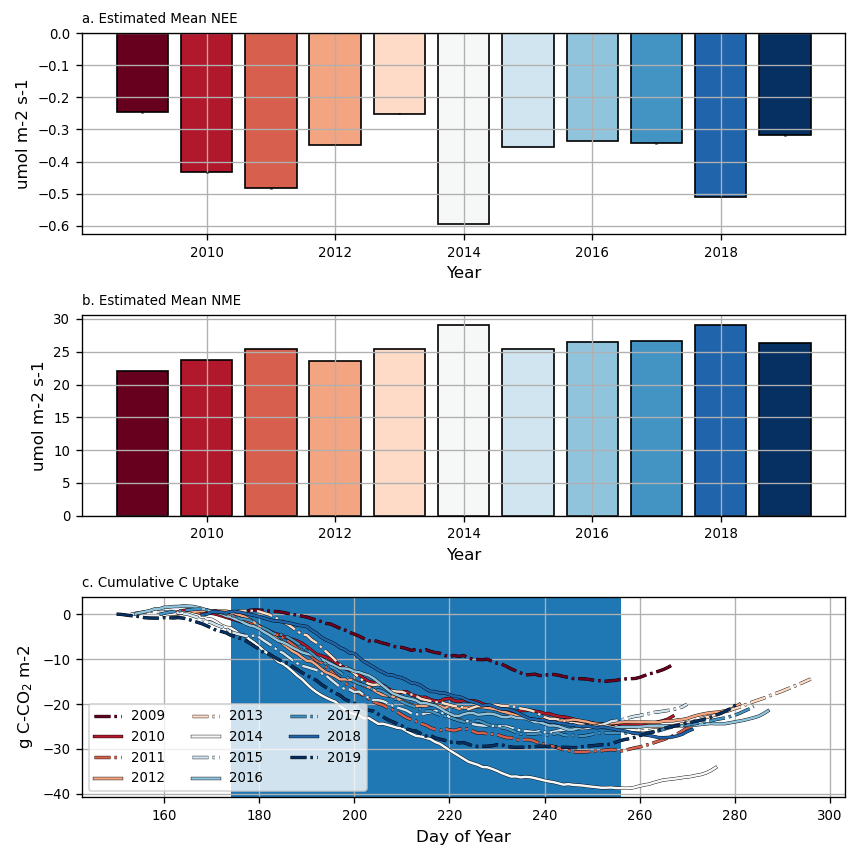

    Estimates  95% CI/PI  Year
0       22.00        0.0  2009
1       23.61        0.0  2012
2       23.69        0.0  2010
3       25.35        0.0  2015
4       25.40        0.0  2011
5       25.46        0.0  2013
6       26.33        0.0  2019
7       26.52        0.0  2016
8       26.70        0.0  2017
9       29.01        0.0  2018
10      29.15        0.0  2014
2009 0

2010 1

2011 2

2012 3

2013 4

2014 5

2015 6

2016 7

2017 8

2018 9

2019 10



In [126]:

mult = {'fco2':(1e-6 * 12.0107 *1800),
#         'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':(1e-9 * 12.0107 *1800)
       }

#normalize item number values to colormap
norm = mpl.colors.Normalize(vmin=0, vmax=10)
Colors = []
for i in range(0,11):
#     rgba_color = cm.RdYlBu(norm(i)) 
    rgba_color = cm.RdBu(norm(i)) 
#     print(rgba_color)viridis
    Colors.append(rgba_color)
    
Temp = All.loc[All['Flux']=='NEE']
Temp2 = All.loc[All['Flux']=='NEE'].copy()

print(Temp.sort_values(by='Estimates').reset_index()[['Estimates','95% CI/PI','Year']].round(2))

print('-0.60 [CI95% ± 0.4]')

cm_2_in=1/2.54 
fig,ax=plt.subplots(3,figsize=(18.2*cm_2_in, 18.2*cm_2_in))


ax[0].bar(Temp['Year'],Temp['Estimates'],yerr=Temp['95% CI/PI'],color=Colors,edgecolor='k')



Temp = All.loc[All['Flux']=='NME']

print(Temp.sort_values(by='Estimates').reset_index()[['Estimates','95% CI/PI','Year']].round(2))

ax[1].bar(Temp['Year'],Temp['Estimates'],yerr=Temp['95% CI/PI'],color=Colors,edgecolor='k')
T = []

for y in T30.index.year.unique():
    if y >2008 and y<2020:
        i = y-2009
        print(y,i)
#         Year = T30.loc[((T30.index.year==y)&
#                         (T30['DOY']>=Start)&(T30['DOY']<=End))].copy()
        Year = T30.loc[((T30.index.year==y)&
                        (T30['DSSM']>0)&
                        (T30['NDVI']>NDVI_Thresh)
                       )].copy()
#         print(Year)
    
        Year['NEE_est'] = Year['NEE_est']*mult['fco2']
        Year['NME_est'] = Year['NME_est']*mult['fch4']
        Year['C']=Year['NEE_est']+Year['NME_est']
        Year=Year[['C']].resample('D').sum().cumsum()
    
        Year['C'] = Year['C']
        print()


        if (y % 2) == 0:
            linestyle='-'
        else:            
            linestyle='-.'
            
        ax[2].plot(Year.index.dayofyear,Year['C'],color=Colors[i],linestyle=linestyle,
                   path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()],label = str(y))
#         ax[1].plot(Year.DOY.resample('D').mean(),Year['NEE_est'].resample('D').sum().cumsum(),color=Colors[i],linestyle=linestyle,
#                    path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()],label = str(y))
#         print(Year.index)
        T.append(Year['C'].resample('D').sum().cumsum().min())
        
ax[0].set_title('a. Estimated Mean NEE',loc='left')
ax[0].set_ylabel('umol m-2 s-1')
ax[0].grid()
ax[0].set_xlabel('Year')

ax[1].set_title('b. Estimated Mean NME',loc='left')
ax[1].set_ylabel('umol m-2 s-1')
ax[1].grid()
ax[1].set_xlabel('Year')
# ax[0].set_facecolor([.8,.8,.8])
ax[2].set_title('c. Cumulative C Uptake',loc='left')
ax[2].set_ylabel('g C-CO$_{2}$ m-2')
ax[2].grid()
ax[2].set_xlabel('Day of Year')
ax[2].legend(ncol=3)
ax[2].axvspan(Start,End,-50,10)
# ax[1].set_facecolor([.8,.8,.8])


plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Google Drive\\PhD_Thesis\\Chapter3_Figs/NEE_Estimates.png')

['Net SW Radiation', 'Net LW Radiation ', 'NDVI', 'Deep', 'Shallow', 'VPD_est']
NDVI                -0.670149
VPD_est             -0.314450
Air Temp            -0.196260
Net SW Radiation    -0.182976
Net LW Radiation     0.166362
Shallow              0.211187
Deep                 0.297490
NEE_est              1.000000
Name: NEE_est, dtype: float64


<IPython.core.display.Javascript object>


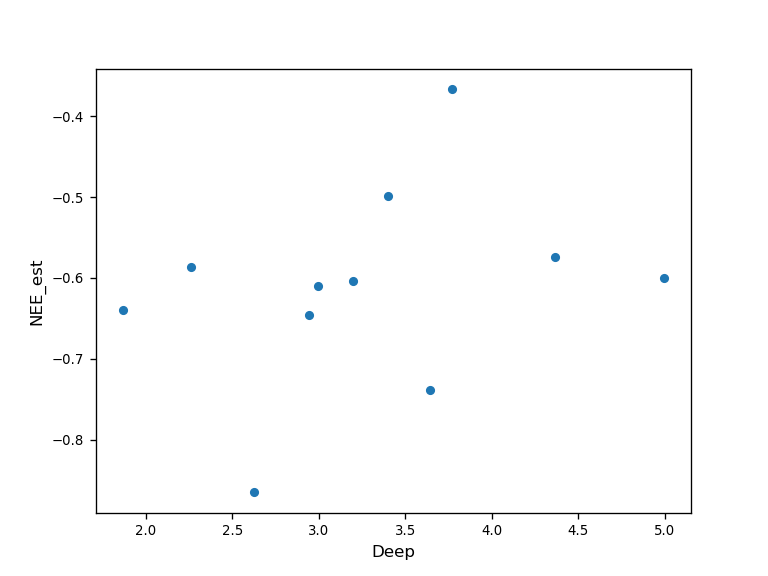

In [217]:
# print()
# print((T30[['NEE_est','NDVI']].resample('H').mean().corr()))

X = 'Deep'
Y = 'NEE_est'
S = 'Y'

# Temp = T30.loc[((T30.index.year>=2009)&
#                 (T30.index.year<=2019)&
#             (T30['DSSM']>0)#&
# #             (T30['NDVI']>NDVI_Thresh)
#                )].resample(S).mean()
Temp = T30.loc[((T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)&
               (T30.index.year>=2009)&(T30.index.year<=2019))].resample(S).mean()

print(fco2.Model.split('+'))
print(Temp[fco2.Model.split('+')+['Air Temp',Y]].corr()[Y].sort_values())
Temp.plot(kind='scatter',x=X,y=Y)


    Estimates  95% CI/PI  Year
0       -0.59        0.0  2014
1       -0.51        0.0  2018
2       -0.48        0.0  2011
3       -0.43        0.0  2010
4       -0.35        0.0  2015
5       -0.35        0.0  2012
6       -0.34        0.0  2017
7       -0.34        0.0  2016
8       -0.32        0.0  2019
9       -0.25        0.0  2013
10      -0.25        0.0  2009
-0.60 [CI95% ± 0.4]


<IPython.core.display.Javascript object>


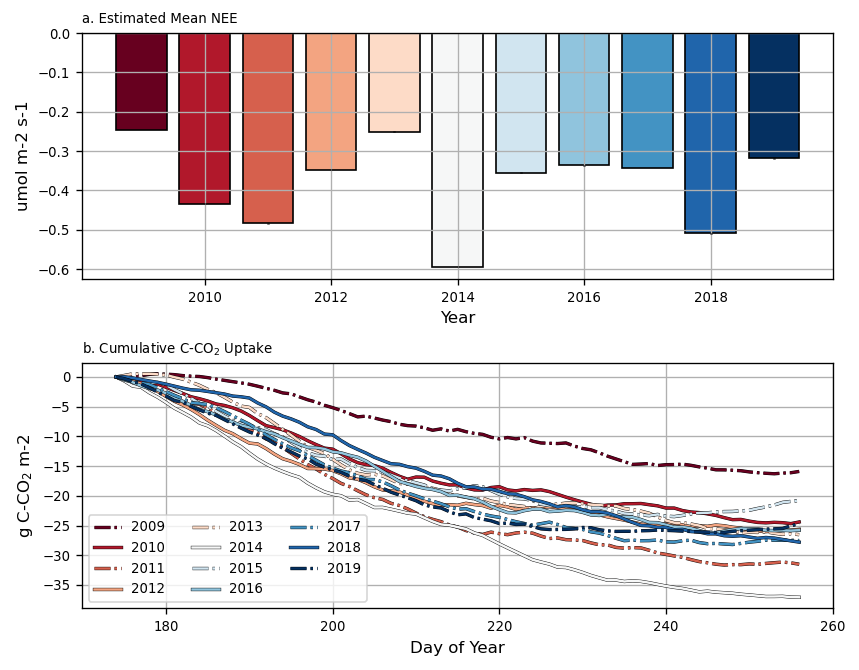

2009 0

2010 1

2011 2

2012 3

2013 4

2014 5

2015 6

2016 7

2017 8

2018 9

2019 10



In [173]:

mult = {'fco2':(1e-6 * 12.0107 *1800),
#         'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':(1e-9 * 12.0107 *1800)
       }

#normalize item number values to colormap
norm = mpl.colors.Normalize(vmin=0, vmax=10)
Colors = []
for i in range(0,11):
#     rgba_color = cm.RdYlBu(norm(i)) 
    rgba_color = cm.RdBu(norm(i)) 
#     print(rgba_color)viridis
    Colors.append(rgba_color)
    
Temp = All.loc[All['Flux']=='NEE']
Temp2 = All.loc[All['Flux']=='NEE'].copy()

print(Temp.sort_values(by='Estimates').reset_index()[['Estimates','95% CI/PI','Year']].round(2))

print('-0.60 [CI95% ± 0.4]')

cm_2_in=1/2.54 
fig,ax=plt.subplots(2,figsize=(18.2*cm_2_in, 14.2*cm_2_in))


ax[0].bar(Temp['Year'],Temp['Estimates'],yerr=Temp['95% CI/PI'],color=Colors,edgecolor='k')
T = []

for y in T30.index.year.unique():
    if y >2008 and y<2020:
        i = y-2009
        print(y,i)
        Year = T30.loc[((T30.index.year==y)&
                        (T30['DOY']>=Start)&(T30['DOY']<=End))].copy()
#         Year = T30.loc[((T30.index.year==y)&
#                         (T30['DSSM']>0)&
#                         (T30['NDVI']>NDVI_Thresh)
#                        )].copy()
#         print(Year)
    
        Year['NEE_est'] = Year['NEE_est']*mult['fco2']
        Year=Year[['NEE_est']].resample('D').sum().cumsum()
    
        array = Year['NEE_est'].to_numpy()    
        array = np.flip(array)  # to flip the order 
        array = np.cumsum(array)    
        array =  np.flip(array)  # to flip back to original order    
        Year['NEE_est_temp'] = array
        Year['NEE_est_temp'] = Year['NEE_est_temp']-Year.loc[Year.index.dayofyear==174,'NEE_est_temp'].values[0]
        
        
        Year['NEE_est'] = Year['NEE_est']-Year.loc[Year.index.dayofyear==174,'NEE_est'].values[0]
        
        Year['NEE_cumsum'] = Year['NEE_est']
        
# #         Year
#         Year['NEE_cumsum'] =  Year['NEE_est_temp']
        
        
#         Year.loc[Year.index.dayofyear>=174,'NEE_cumsum']=Year.loc[Year.index.dayofyear>=174,'NEE_est']
        Year.loc[Year.index.dayofyear<174,'NEE_cumsum']*=-1#Year.loc[Year.index.dayofyear<174,'NEE_est_temp']#*-1
        print()


        if (y % 2) == 0:
            linestyle='-'
        else:            
            linestyle='-.'
            
        ax[1].plot(Year.index.dayofyear,Year['NEE_cumsum'],color=Colors[i],linestyle=linestyle,
                   path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()],label = str(y))
#         ax[1].plot(Year.DOY.resample('D').mean(),Year['NEE_est'].resample('D').sum().cumsum(),color=Colors[i],linestyle=linestyle,
#                    path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()],label = str(y))
#         print(Year.index)
        T.append(Year['NEE_est'].resample('D').sum().cumsum().min())
        
ax[0].set_title('a. Estimated Mean NEE',loc='left')
ax[0].set_ylabel('umol m-2 s-1')
ax[0].grid()
ax[0].set_xlabel('Year')
# ax[0].set_facecolor([.8,.8,.8])
ax[1].set_title('b. Cumulative C-CO$_{2}$ Uptake',loc='left')
ax[1].set_ylabel('g C-CO$_{2}$ m-2')
ax[1].grid()
ax[1].set_xlabel('Day of Year')
ax[1].legend(ncol=3)
# ax[1].set_facecolor([.8,.8,.8])


plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Google Drive\\PhD_Thesis\\Chapter3_Figs/NEE_Estimates.png')

    Estimates  95% CI/PI  Year
0       22.00        0.0  2009
1       23.61        0.0  2012
2       23.69        0.0  2010
3       25.35        0.0  2015
4       25.40        0.0  2011
5       25.46        0.0  2013
6       26.33        0.0  2019
7       26.52        0.0  2016
8       26.70        0.0  2017
9       29.01        0.0  2018
10      29.15        0.0  2014
Paper Est: 27.26 [CI95% ± 0.36]


<IPython.core.display.Javascript object>


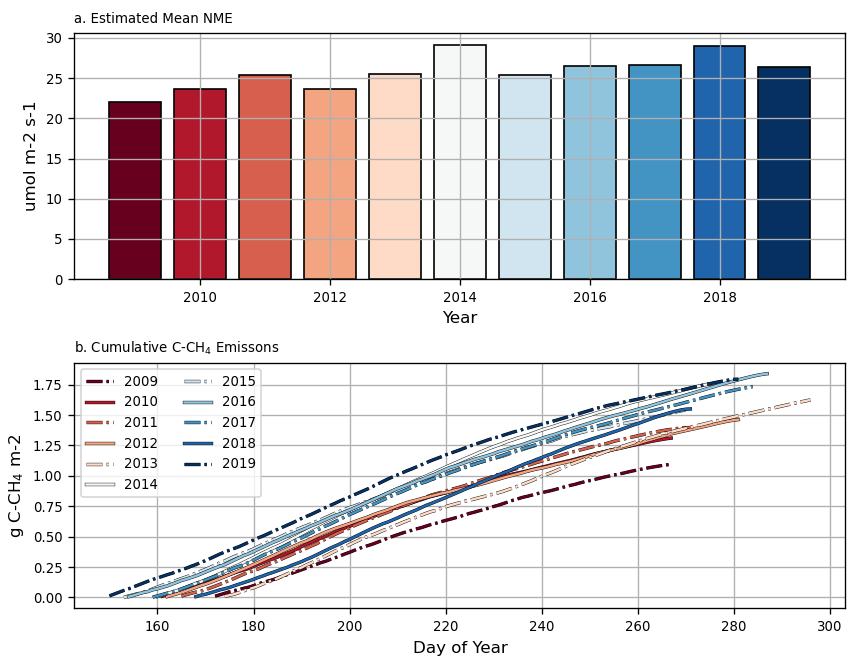

In [121]:
   
Temp = All.loc[All['Flux']=='NME']

print(Temp.sort_values(by='Estimates').reset_index()[['Estimates','95% CI/PI','Year']].round(2))
print('Paper Est: 27.26 [CI95% ± 0.36]')

cm_2_in=1/2.54 
fig,ax=plt.subplots(2,figsize=(18.2*cm_2_in, 14.2*cm_2_in))


ax[0].bar(Temp['Year'],Temp['Estimates'],yerr=Temp['95% CI/PI'],color=Colors,edgecolor='k')

T2 = []

for y in T30.index.year.unique():
    if y >2008 and y<2020:
        i = y-2009
#         Year = T30.loc[((T30.index.year==y)&
#                         (T30['DOY']>=Start)&(T30['DOY']<=End))].copy()

        Year = T30.loc[((T30.index.year==y)&
                        (T30['NDVI']>NDVI_Thresh)&
                        (T30['DSSM']>0)
                       )].copy()
        Year['NME_est'] = Year['NME_est']*mult['fch4']
        if (y % 2) == 0:
            linestyle='-'
        else:            
            linestyle='-.'
        ax[1].plot(Year.DOY.resample('D').mean(),Year['NME_est'].resample('D').sum().cumsum(),color=Colors[i],linestyle=linestyle,
                   path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()],label = str(y))
       
        T2.append(Year['NME_est'].resample('D').sum().cumsum().max())
ax[0].set_title('a. Estimated Mean NME',loc='left')
ax[0].set_ylabel('umol m-2 s-1')
ax[0].grid()
ax[0].set_xlabel('Year')
# ax[0].set_facecolor([.8,.8,.8])
ax[1].set_title('b. Cumulative C-CH$_{4}$ Emissons',loc='left')
ax[1].set_ylabel('g C-CH$_{4}$ m-2')
ax[1].grid()
ax[1].set_xlabel('Day of Year')
ax[1].legend(ncol=2)

plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Google Drive\\PhD_Thesis\\Chapter3_Figs/NME_Estimates.png')

<IPython.core.display.Javascript object>


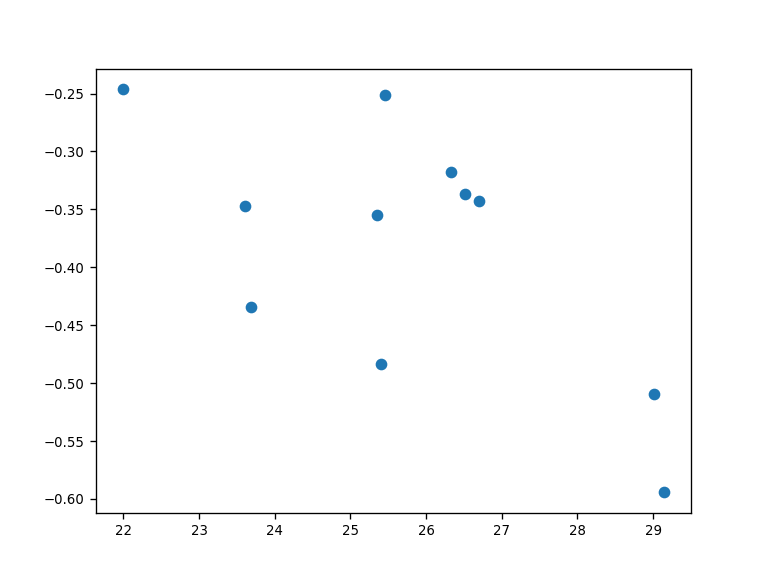

0.40794836417699576
0.40794836417699565
         NEE_est  NME_est
NEE_est  1.00000  0.95394
NME_est  0.95394  1.00000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [127]:
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
plt.figure()
plt.scatter(Temp['Estimates'],Temp2['Estimates'])
# plt.scatter(Temp['Estimates'],Temp2['Estimates'])
Mod = LinearRegression()
Mod.fit(Temp2[['Estimates']], Temp['Estimates'])
print(Mod.score(Temp2[['Estimates']], Temp['Estimates']))
corr, _ = pearsonr(Temp2['Estimates'], Temp['Estimates'])
print(corr**2)

print(T30[['NEE_est','NME_est']].corr()**2)
T = np.array(T)
T2 = np.array(T2)
print((((T-T2)-T)/T).round(2))

<IPython.core.display.Javascript object>


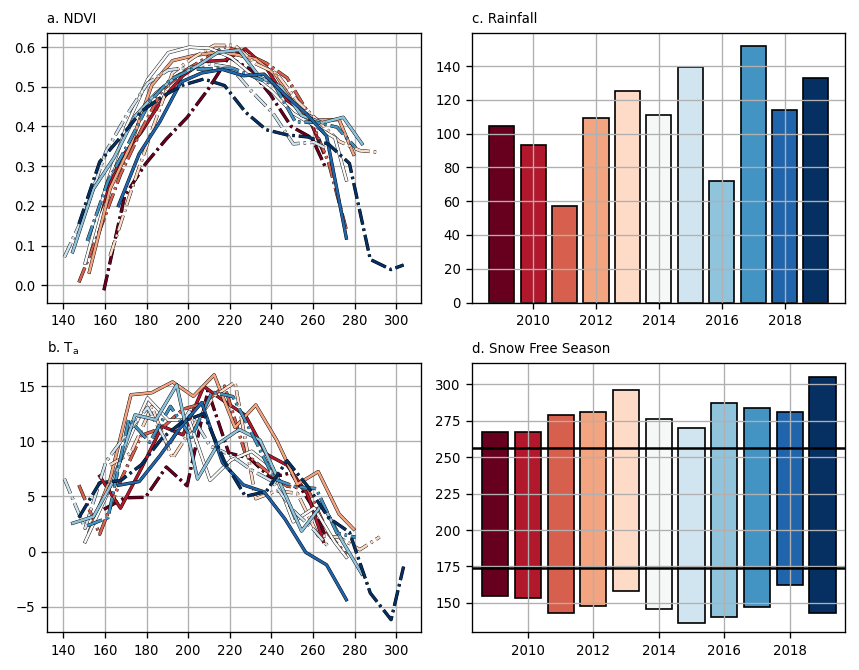

2009 155 267.0
2010 153 267.0
2011 143 279.0
2012 148 281.0
2013 158 296.0
2014 146 276.0
2015 136 270.0
2016 140 287.0
2017 147 284.0
2018 162 281.0
2019 143 305.0


In [128]:

fig,ax=plt.subplots(2,2,figsize=(18.2*cm_2_in, 14.2*cm_2_in))#,sharex=True)
# GS['AirTemp_Avg'].plot()
GSS = []
GSD = []
for y in T30.index.year.unique():
    if y > 2008 and y<2020:
        i = y-2009
#         Year = T30.loc[((T30.index.year==y)&
#                         (T30['DOY']>=Start)&(T30['DOY']<=End))]
        
        Year = T30.loc[((T30.index.year==y)&
                        (T30['DSSM']>0))
                      ].copy()
        YearM = Year.resample('10D').mean()

        if (y % 2) == 0:
            linestyle='-'
        else:            
            linestyle='-.'
        ax[1,0].plot(YearM.DOY,YearM['Air Temp'],color = Colors[i],linestyle=linestyle,
                   path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
        ax[0,0].plot(YearM['DOY'],YearM['NDVI'],label=y,color = Colors[i],linestyle=linestyle,
                   path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
                   
#         Year = T30.loc[(T30.index.year==y)]

        ax[0,1].bar(y,Year['Rainfall'].sum(),color = Colors[i],edgecolor='k')##linestyle=linestyle,
#                    path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
    
        Year = T30.loc[(T30.index.year==y)]
        ax[1,1].bar(y,Year['DSSM'].max(),bottom=Year.loc[Year['DSSM']>0,'DOY'].values[0],
                  color = Colors[i],edgecolor='k')
        print(y,Year.loc[Year['DSSM']>0,'DOY'].values[0],Year['DSSM'].max()+Year.loc[Year['DSSM']>0,'DOY'].values[0])
        GSS.append(Year.loc[Year['DSSM']>0,'DOY'].values[0])
        GSD.append(Year['DSSM'].max())
ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()


ax[1,0].set_title('b. T$_{a}$',loc='left')
ax[0,0].set_title('a. NDVI',loc='left')
ax[0,1].set_title('c. Rainfall',loc='left')
ax[1,1].set_title('d. Snow Free Season',loc='left')


ax[1,1].plot([2008,2020],[Start,Start],color='k')
ax[1,1].plot([2008,2020],[End,End],color='k')
ax[1,1].set_xlim(2008.3,2019.7)    
ax[1,1].set_ylim(130,315)    

plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Google Drive\\PhD_Thesis\\Chapter3_Figs/ClimateData.png')

In [ ]:
print(T30.loc[T30['fco2'].isnull()==False,'NDVI'].describe())